# Imports

In [1]:
from datasets import load_dataset, load_from_disk
from collections import Counter
from multiprocessing import Pool
import regex as re
from tqdm import tqdm
import pickle
from encoder import TextEncoder, tokenize_and_write_shards
import os
import utils
import numpy as np
from torch import nn
import json

# Download the dataset
datasets_path = "datasets/wikipedia"
model_path = "models/tinyllm"
os.makedirs(datasets_path, exist_ok=True)

# Load data

## Download Wikipedia data

In [2]:
# download wikipedia dataset and save it to a file
# os.makedirs(datasets_path, exist_ok=True)
# dataset = load_dataset("wikimedia/wikipedia", "20231101.en")
# dataset.save_to_disk(datasets_path)

## Load the dataset from the local file

In [3]:
dataset = load_from_disk(datasets_path)["train"]
print(f"{len(dataset):,} articles")
doc = dataset[0]
print(doc.keys())
print(doc["text"])

Loading dataset from disk:   0%|          | 0/41 [00:00<?, ?it/s]

6,407,814 articles
dict_keys(['id', 'url', 'title', 'text'])
Anarchism is a political philosophy and movement that is skeptical of all justifications for authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy, typically including nation-states, and capitalism. Anarchism advocates for the replacement of the state with stateless societies and voluntary free associations. As a historically left-wing movement, this reading of anarchism is placed on the farthest left of the political spectrum, usually described as the libertarian wing of the socialist movement (libertarian socialism).

Humans have lived in societies without formal hierarchies long before the establishment of states, realms, or empires. With the rise of organised hierarchical bodies, scepticism toward authority also rose. Although traces of anarchist ideas are found all throughout history, modern anarchism emerged from the Enlightenment. During the latter half of the 19th and th

# Count words

## Count words in the dataset and save in pickle

took `32 minutes` to run the code below

In [4]:
# chunk_size = 20_000
# word_counts = Counter()
# for i in tqdm(range(0, len(dataset), chunk_size)):
#     chunk = dataset[i:i + chunk_size]
#     word_counts += utils.count_words_in_documents(chunk["text"], processes=32)
# with open(f"{datasets_path}/word_counts.pkl", "wb") as f:
#     pickle.dump(word_counts, f)
# word_counts_str = {bytes(word).decode("utf-8"): count for word, count in word_counts.items()}
# with open(f"{datasets_path}/word_counts.json", "w") as f:
#     json.dump(word_counts_str, f)
# len(word_counts_str), word_counts_str

## Load the word count from the pickle file

In [5]:
# with open(f"{datasets_path}/word_counts.pkl", "rb") as f:
#     word_counts = pickle.load(f)
# with open(f"{datasets_path}/word_counts.json", "r") as f:
#     word_counts_str = json.load(f)
# f"{len(word_counts_str):,}", word_counts_str

# Train BPE

## Train BPE model

In [6]:
# vocab_size = 2**8 + 500 # 300
# text_encoder = TextEncoder()
# text_encoder.train(word_counts, vocab_size=vocab_size, processes=32)
# text_encoder.save(model_path)

## Test BPE

In [7]:
tokenizer = TextEncoder.load(model_path)
assert tokenizer.decode(tokenizer.encode("Hello universe, there is a lot to learn from you")) == "Hello universe, there is a lot to learn from you", "Tokenizer is not working correctly"

# Tokenize

In [8]:
# !rm -rf {datasets_path}/shards
# shard_size = 50_000_000
# nprocs = 32
# total_tokens = tokenize_and_write_shards(
#     ds=dataset,
#     shard_size=shard_size,
#     nprocs=nprocs,
#     shards_dir=f"{datasets_path}/shards",
#     model_path=model_path,
# )
# total_train_tokens = total_tokens - shard_size # first shard is for validation
# print(f"Total tokens: {total_train_tokens:,}")

# Training

In [9]:
import torch
import inspect

def configure_adamw_optimizer(
        model: torch.nn.Module, 
        weight_decay: float, 
        learning_rate: float,
        betas: tuple,
        eps: float, 
        device_type: str
    ):
    param_dict = {pn: p for pn, p in model.named_parameters() if p.requires_grad}
    decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
    nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
    optim_groups = [
        {'params': decay_params, 'weight_decay': weight_decay},
        {'params': nodecay_params, 'weight_decay': 0.0}
    ]
    use_fused = 'fused' in inspect.signature(torch.optim.AdamW).parameters and device_type == "cuda"
    optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, eps=eps, fused=use_fused)
    return optimizer

In [ ]:
from trainer import TrainerParams, Trainer
import torch.optim as optim
from model import ModelParams, TinyLLM
from dataset import TinyLLMDataset
from torch.utils.data import DataLoader
import dataclasses

model_params = ModelParams(vocab_size=len(tokenizer.vocab))
print(dataclasses.asdict(model_params))
model = TinyLLM(model_params)
model.to(model_params.device)
print(f"Number of parameters: {model._num_parameters():,}")

learning_rate = 2e-3
batch_size = 8
total_train_tokens = 226_052_077
optimizer = configure_adamw_optimizer(model, weight_decay=1e-2, learning_rate=learning_rate, betas=(0.9, 0.95), eps=1e-8, device_type=model_params.device)
training_dataset = TinyLLMDataset(shards_path=f"{datasets_path}/shards", T=model_params.context_length, split='train', total_tokens=total_train_tokens)
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=False)
loss_fn = nn.CrossEntropyLoss()
train_params = TrainerParams(model=model, train_data=training_dataloader, optimizer=optimizer, gpu_id=0, save_every=1, loss_fn=loss_fn)
trainer = Trainer(train_params)
model = trainer.train(1, steps=4000)

{'context_length': 512, 'vocab_size': 757, 'num_blocks': 12, 'num_heads': 12, 'd_model': 768, 'head_dim': 64, 'dropout_rate': 0.1, 'num_of_hidden_units': 3072, 'device': 'cuda'}
Number of parameters: 86,031,349
found 5 shards for split train
[GPU0] Epoch 0 | Batchsize: 8 | Steps: 55,081
Step 100/55081 | Loss: 5.102 | Norm: 0.823
Step 200/55081 | Loss: 4.976 | Norm: 0.781
Step 300/55081 | Loss: 5.027 | Norm: 0.430
Step 400/55081 | Loss: 5.147 | Norm: 0.573
Step 500/55081 | Loss: 4.888 | Norm: 0.365
Step 600/55081 | Loss: 4.760 | Norm: 0.445
Step 700/55081 | Loss: 4.827 | Norm: 0.375
Step 800/55081 | Loss: 4.701 | Norm: 0.323
Step 900/55081 | Loss: 4.761 | Norm: 0.337
Step 1000/55081 | Loss: 4.525 | Norm: 0.256
Step 1100/55081 | Loss: 4.666 | Norm: 0.275
Step 1200/55081 | Loss: 5.076 | Norm: 0.421
Step 1300/55081 | Loss: 4.724 | Norm: 0.269
Step 1400/55081 | Loss: 4.563 | Norm: 0.221
Step 1500/55081 | Loss: 4.583 | Norm: 0.288
Step 1600/55081 | Loss: 4.663 | Norm: 0.314
Step 1700/55081 |

In [ ]:
# generate text
import torch
text = "The moon is"
text_ids = tokenizer.encode(text)
text_ids = torch.tensor(text_ids, device=model_params.device).unsqueeze(0)
generated_ids = trainer.model.generate(text_ids, 100)
string = tokenizer.decode(generated_ids[0].tolist())
print(string)

The moon ises(Ea,T T( at  inandand aand  andit p19991/36IIin  th tn  "nsra K� ataton;tm D thy )he.nimisises toofeee


AA fep   mieratlanwhhigentes Sunop F  sth 


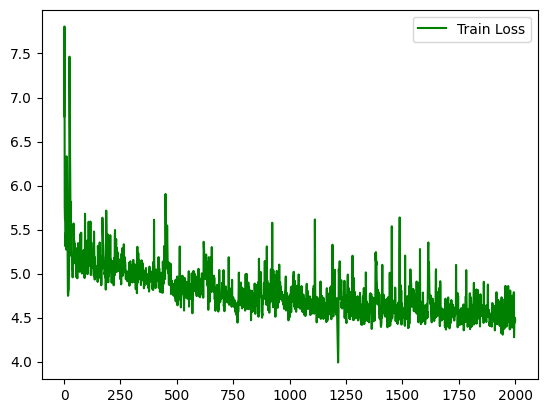

In [ ]:
import seaborn as sns

def plot_loss_curve(epochs,train_loss_values,test_loss_values):
    sns.lineplot(x=epochs,y=train_loss_values,label='Train Loss',color='green')
    if test_loss_values:
        sns.lineplot(x=epochs,y=test_loss_values)

plot_loss_curve(trainer.train_steps, trainer.train_losses, None)   